# Solar Orbiter paper on first ICME April 2020

## Figure 1, positions, in situ data Solar Orbiter (mag), Wind (mag and plasma)

In [3]:
import numpy as np
import scipy.io
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import  DateFormatter
from datetime import timedelta
import seaborn as sns
import datetime
import astropy
import astropy.constants as const
from sunpy.time import parse_time
import time
import pickle
import sys
import os
import urllib
import json
import importlib
import pandas as pd
import copy
import openpyxl
import h5py
import heliopy.data.spice as spicedata
import heliopy.spice as spice
import heliosat

#because script is not in root directory of package
#sys.path.append('/Users/chris/python/heliocats')
sys.path.append('/home/cmoestl/pycode/heliocats')
import heliocats.data as hd
from config import data_path

from astropy.constants import au
#define AU in km
AU=au.value/1e3

## convert data from cdf to pickle

In [12]:
DATAPATH = "../data/solo_mag/event1"

class SOIO_EXT(heliosat.SOIO):
    def get_data_files(self, *args):
        files = os.listdir(DATAPATH)
        files.sort()
        files = [os.path.join(DATAPATH, f) for f in files]
        return files, [self.get_data_version("mag", datetime.datetime.now())] * len(files)
  

a = SOIO_EXT()
#time for 7 days
time = [datetime.datetime(2020, 4, 15) + datetime.timedelta(minutes=i) for i in range(60 * 24 * 7 )]
time_mat=mdates.date2num(time) 


#_, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ")

# t_soio = [datetime.datetime(2020, 5, 27) + datetime.timedelta(hours=i) for i in range(24 * 7)]
# _, b_soio = SOIO_EXT().get_data(t_soio, "mag", frame="HEEQ", cache=True, smoothing="kernel",
#                                 smoothing_scale=240, remove_nans=True)


#original data
print('get data')
t2, b_soio = SOIO_EXT().get_data(time, "mag")#,frame="HEEQ")
t1=parse_time(t2,format='unix').datetime
tm_mat=mdates.date2num(t1) 

smag=np.zeros(np.size(time),dtype=[('time',object),('bx', float),('by', float),\
        ('bz', float),('bt', float),\
        ('vt', float),('np', float), ('tp', float),\
                                   ('x', float),('y', float),('z', float),\
        ('r', float),('lat', float),('lon', float)])  
smag = smag.view(np.recarray) 

print('interpolate')
smag.time=time
smag.bx = np.interp(time_mat, tm_mat, b_soio[:, 0])
smag.by = np.interp(time_mat, tm_mat, b_soio[:, 1])
smag.bz = np.interp(time_mat, tm_mat, b_soio[:, 2])
smag.bt =np.sqrt(smag.bx**2+smag.by**2+smag.bz**2)


print('Solo position')


#add position

frame='HEEQ'
spice.furnish(spicedata.get_kernel('solo_2020'))
solo=spice.Trajectory('Solar Orbiter')
solo.generate_positions(smag.time, 'Sun',frame)
solo.change_units(astropy.units.AU)
[smag.r, smag.lat, smag.lon]=hd.cart2sphere(solo.x,solo.y,solo.z)


#convert to degree
smag.lat=np.rad2deg(smag.lat)
smag.lon=np.rad2deg(smag.lon)


smag.x=solo.x.value
smag.y=solo.y.value
smag.z=solo.z.value





#set solo mag to nan after Apr 21
nanind=np.where(smag.time > parse_time('2020-04-21').datetime)

smag.bt[nanind]=np.nan
smag.bx[nanind]=np.nan
smag.by[nanind]=np.nan
smag.bz[nanind]=np.nan



#maybe use RTN to SCEQ or HEEQ from hd.

filemag='../data/solo_april2020.p'
pickle.dump(smag, open(filemag, "wb"))

get data
interpolate
Solo position


## load in situ data and positions

In [21]:
filemag=data_path+'solo_april2020.p'
sm=pickle.load(open(filemag, "rb" ) ) 


filewin=data_path+'wind_2018_now_gse.p'
[win,hwin]=pickle.load(open(filewin, "rb" ) )


filebepi='bepi_2020_march_sept_hee.p'
bm=pickle.load(open(data_path+filebepi, "rb" ) )      




#set bepi mag to nan after Apr 21
nanind=np.where(bm.time > parse_time('2020-04-21 18:00').datetime)

bm.bt[nanind]=np.nan
bm.bx[nanind]=np.nan
bm.by[nanind]=np.nan
bm.bz[nanind]=np.nan


[psp, bepi, solo, sta, earth, venus, mars, mercury,frame]= \
      pickle.load( open( '../data/positions_psp_solo_bepi_sta_planets_HEEQ_1hour.p', "rb" ))

## Results

In [5]:
#%matplotlib inline
#%matplotlib
#hp.plot_insitu_measure(sm, '2020-Apr-18 12:00','2020-Apr-21 12:00', 'Solo', 'results/')
#hp.plot_insitu_measure(win, '2020-Apr-18 12:00','2020-Apr-23 12:00', 'Wind', 'results/')

######################### solo
sicme_start_time=parse_time('2020-04-19T05:07Z').datetime
smo_start_time=parse_time('2020-04-19T08:59Z').datetime
smo_end_time=parse_time('2020-04-20T09:15Z').datetime

print('SolO times:',sicme_start_time, smo_start_time,smo_end_time)

#index of times
sicme_start_ind=np.where(sicme_start_time==sm.time)[0][0]
smo_start_ind=np.where(smo_start_time==sm.time)[0][0]
smo_end_ind=np.where(smo_end_time==sm.time)[0][0]

print('HEEQ position of SolO r/lat/lon at icme_start_time:',np.round(sm.r[sicme_start_ind],3),np.round(sm.lat[sicme_start_ind],2),np.round(sm.lon[sicme_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_start_time:',np.round(sm.r[smo_start_ind],3),np.round(sm.lat[smo_start_ind],2),np.round(sm.lon[smo_start_ind],2))
print('HEEQ position of SolO r/lat/lon at mo_end_time:',np.round(sm.r[smo_end_ind],3),np.round(sm.lat[smo_end_ind],2),np.round(sm.lon[smo_end_ind],2))



print('SolO ICME duration hours ', np.round((smo_end_time-sicme_start_time).total_seconds()/3600,2))
print('SolO MO duration hours ', np.round((smo_end_time-smo_start_time).total_seconds()/3600,2))
print()

########################## Wind
wicme_start_time=parse_time('2020-04-20T01:34Z').datetime
wmo_start_time=parse_time('2020-04-20T07:56Z').datetime
wmo_end_time=parse_time('2020-04-21T11:18Z').datetime

print('Wind times:',wicme_start_time, wmo_start_time,wmo_end_time)
print('Wind ICME duration hours ', np.round((wmo_end_time-wicme_start_time).total_seconds()/3600,2))
print('Wind MO duration hours ', np.round((wmo_end_time-wmo_start_time).total_seconds()/3600,2))


#index of times
wicme_start_ind=np.where(wicme_start_time==win.time)[0][0]
wmo_start_ind=np.where(wmo_start_time==win.time)[0][0]
wmo_end_ind=np.where(wmo_end_time==win.time)[0][0]

print('HEEQ position of Wind r/lat/lon at icme_start_time:',np.round(win.r[wicme_start_ind],3),np.round(win.lat[wicme_start_ind],2),np.round(win.lon[wicme_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_start_time:',np.round(win.r[wmo_start_ind],3),np.round(win.lat[wmo_start_ind],2),np.round(win.lon[wmo_start_ind],2))
print('HEEQ position of Wind r/lat/lon at mo_end_time:',np.round(win.r[wmo_end_ind],3),np.round(win.lat[wmo_end_ind],2),np.round(win.lon[wmo_end_ind],2))


SolO times: 2020-04-19 05:07:00 2020-04-19 08:59:00 2020-04-20 09:15:00
HEEQ position of SolO r/lat/lon at icme_start_time: 0.806 -3.9 -4.61
HEEQ position of SolO r/lat/lon at mo_start_time: 0.805 -3.89 -4.56
HEEQ position of SolO r/lat/lon at mo_end_time: 0.799 -3.77 -4.28
SolO ICME duration hours  28.13
SolO MO duration hours  24.27

Wind times: 2020-04-20 01:34:00 2020-04-20 07:56:00 2020-04-21 11:18:00
Wind ICME duration hours  33.73
Wind MO duration hours  27.37
HEEQ position of Wind r/lat/lon at icme_start_time: 0.996 -5.21 0.19
HEEQ position of Wind r/lat/lon at mo_start_time: 0.996 -5.19 0.19
HEEQ position of Wind r/lat/lon at mo_end_time: 0.996 -5.09 0.18


### Make plot

HEEQ
current frame_time_num 2020-04-20 00:00:00+00:00


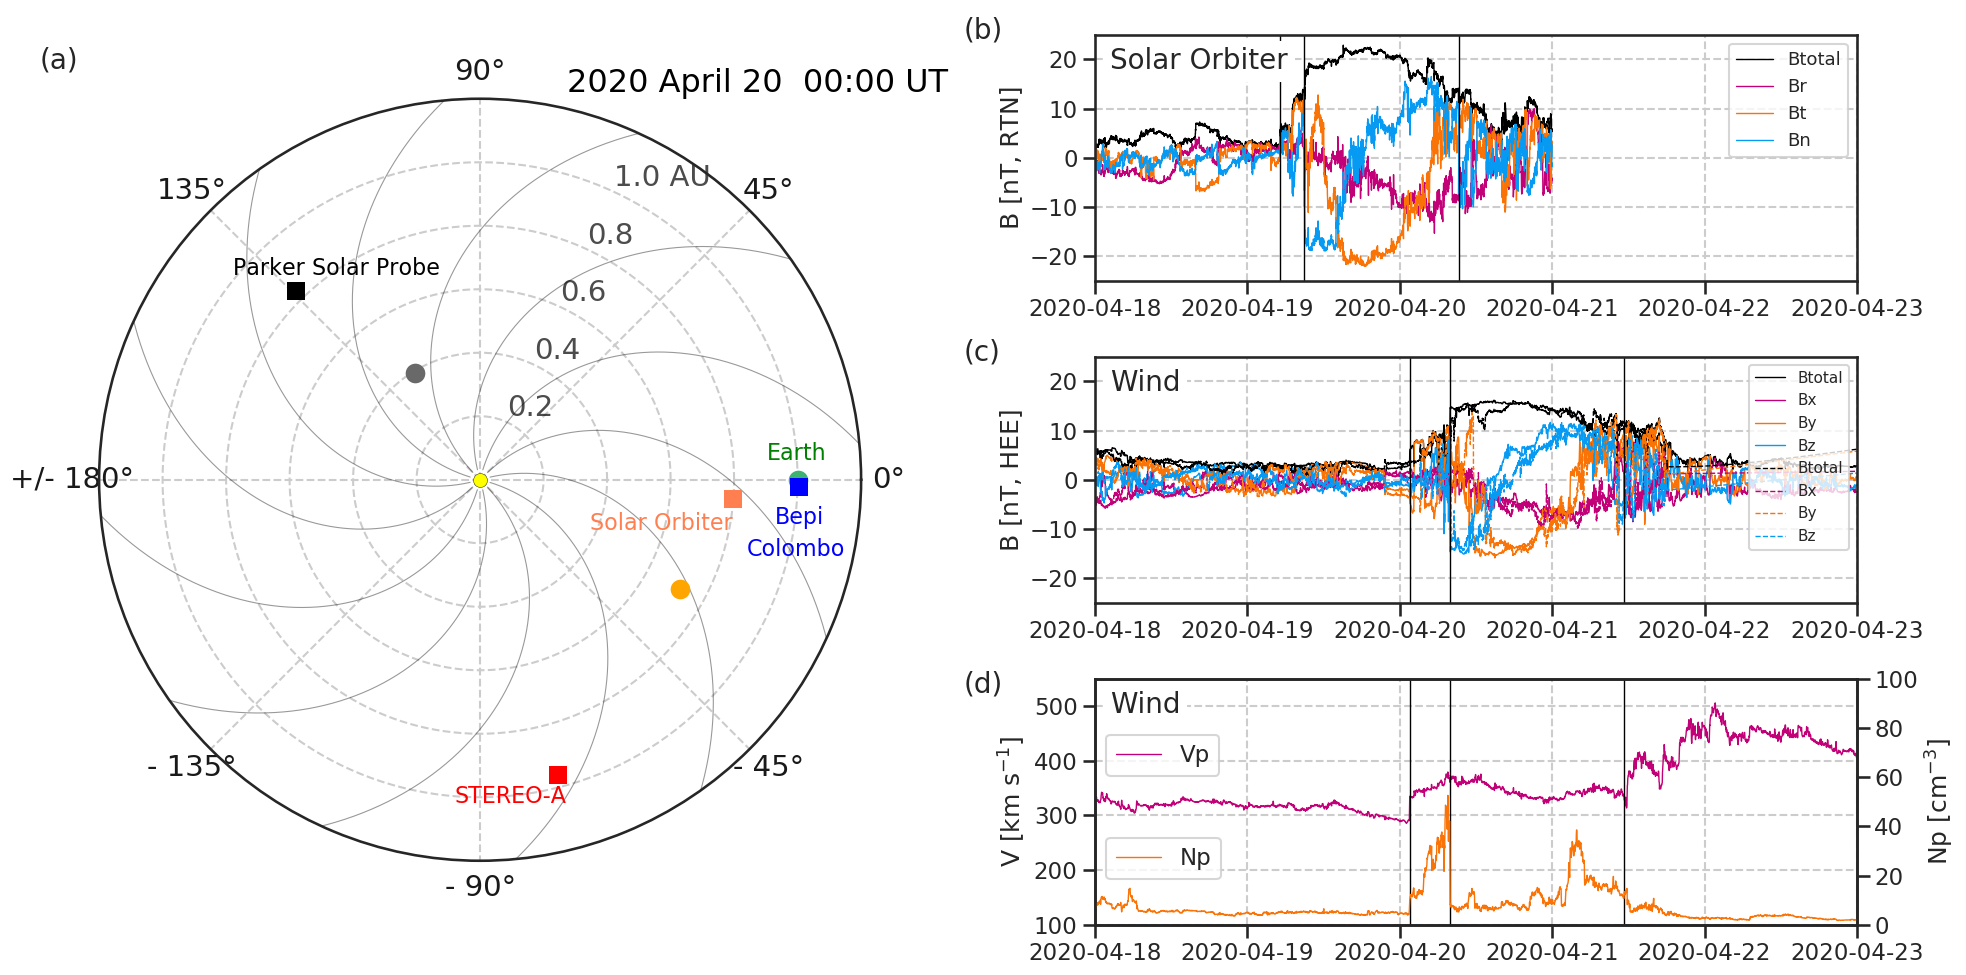

In [11]:
sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})



#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,23)
blim=25

plt.figure(1,figsize=(20, 10),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((3, 2), (0, 1))  #solo b
ax2 = plt.subplot2grid((3, 2), (1, 1))  #wind b
ax4 = plt.subplot2grid((3, 2), (2, 1))  #wind v
ax3 = plt.subplot2grid((3, 2), (0, 0), rowspan=3, projection='polar') #positions


#########################################################################
backcolor='black'
psp_color='black'
bepi_color='blue'
solo_color='coral'

symsize_planet=200
symsize_spacecraft=150
fsize=20
plot_orbit=True
fadeind=150

plot_parker=True

AUkm=149597870.7   

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

frame_time_num=mdates.date2num(parse_time('2020-Apr-20').datetime)
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp.time
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi.time
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo.time
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta.time
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth.time
earth_timeind=np.argmin(abs(dct))


ax3.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
ax3.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
ax3.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
ax3.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)

ax3.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
ax3.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
 

#parker spiral
if plot_parker:
    for q in np.arange(0,12):
        omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
        v=400/AUkm #km/s
        r0=695000/AUkm
        r=v/omega*theta+r0*7
        ax3.plot(-theta+np.deg2rad(0+(360/24.47)*1+360/12*q), r, alpha=0.4, lw=0.8,color='black',zorder=1)

#set axes and grid
ax3.set_theta_zero_location('E')
#plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize+1,color=backcolor, alpha=0.9,zorder=4)

#plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
plt.rgrids((0.2,0.4,0.6,0.8,1.0),('0.2','0.4','0.6','0.8','1.0 AU'),angle=65, fontsize=fsize+1,alpha=0.7, color=backcolor)

#ax.set_ylim(0, 1.75) #with Mars
ax3.set_ylim(0, 1.2) 

#Sun
ax3.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)



#spacecraft labels
ax3.text(psp.lon[psp_timeind]-0.2,psp.r[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(solo.lon[solo_timeind]-0.05,solo.r[solo_timeind],'Solar Orbiter', color=solo_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax3.text(bepi.lon[bepi_timeind]-0.06,bepi.r[bepi_timeind],'Bepi', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(bepi.lon[bepi_timeind]-0.16,bepi.r[bepi_timeind],'Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(sta.lon[sta_timeind]-0.16,sta.r[sta_timeind],'STEREO-A', color='red', ha='center',fontsize=fsize-4,verticalalignment='top')
ax3.text(earth.lon[earth_timeind]+0.12,earth.r[earth_timeind],'Earth', color='green', ha='center',fontsize=fsize-4,verticalalignment='top')



#time
ax3.text(1.35,1.25,mdates.num2date(frame_time_num).strftime("%Y %B %d  %H:%M")+' UT',fontsize=fsize+3, ha='left',c='black')






#################### Solo MAG

ax1.plot(sm.time, sm.bt, "k-", lw=1,label='Btotal')
ax1.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]')
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=1,ncol=1,fontsize=13)
ax1.grid(True)


#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
#         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)

 
############################## Wind MFI
    
#plt.title('Wind MFI')

ax2.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax2.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')

ax2.plot(bm.time, bm.bt, "k--", lw=1,label='Btotal')
ax2.plot(bm.time, bm.bx,'--r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(bm.time, bm.by, "g--", color="xkcd:orange", lw=1,label='By')
ax2.plot(bm.time, bm.bz, "b--", color="xkcd:azure", lw=1,label='Bz')


#plot vertical lines
ax2.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax2.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            

ax2.set_ylabel('B [nT, HEE]')
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.legend(loc=1,ncol=1,fontsize=11)
ax2.grid(True)

#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
#         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)


#plt.tight_layout()



############################## Wind SWE


#speed
ax4.plot(win.time, win.vt, color="xkcd:magenta",linewidth=1,label='Vp')

ax4.plot_date([wicme_start_time,wicme_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_start_time,wmo_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_end_time,wmo_end_time],[-500,1000],'-k',linewidth=1)            

ax4.set_ylabel('V [km $\mathrm{s^{-1}}$]')
ax4.set_xlim(plotstart,plotend)
ax4.set_ylim(100,550)
ax4.grid(True)



#density
ax5=ax4.twinx()
ax5.plot(win.time, win.np, color="xkcd:orange", lw=1,label='Np')
ax5.set_ylim(0,100)
ax5.set_ylabel('Np $[\mathrm{cm^{-3}}]$')

ax4.legend(loc=2,bbox_to_anchor=(0.0,0.82))
ax5.legend(loc=2,bbox_to_anchor=(0.0,0.4))



plt.tight_layout()

#annotations

plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.49,0.96],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.49,0.63],xycoords='figure fraction',fontsize=20)
plt.annotate('(d)',[0.49,0.29],xycoords='figure fraction',fontsize=20)

ax2.text(0.02,0.86,'Wind',transform=ax2.transAxes,fontsize=20, bbox=dict(facecolor='white', alpha=1))
ax4.text(0.02,0.86,'Wind',transform=ax4.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))
ax1.text(0.02,0.86,'Solar Orbiter',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))

plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview.png')
plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview.pdf')

HEEQ
current frame_time_num 2020-04-20 00:00:00+00:00


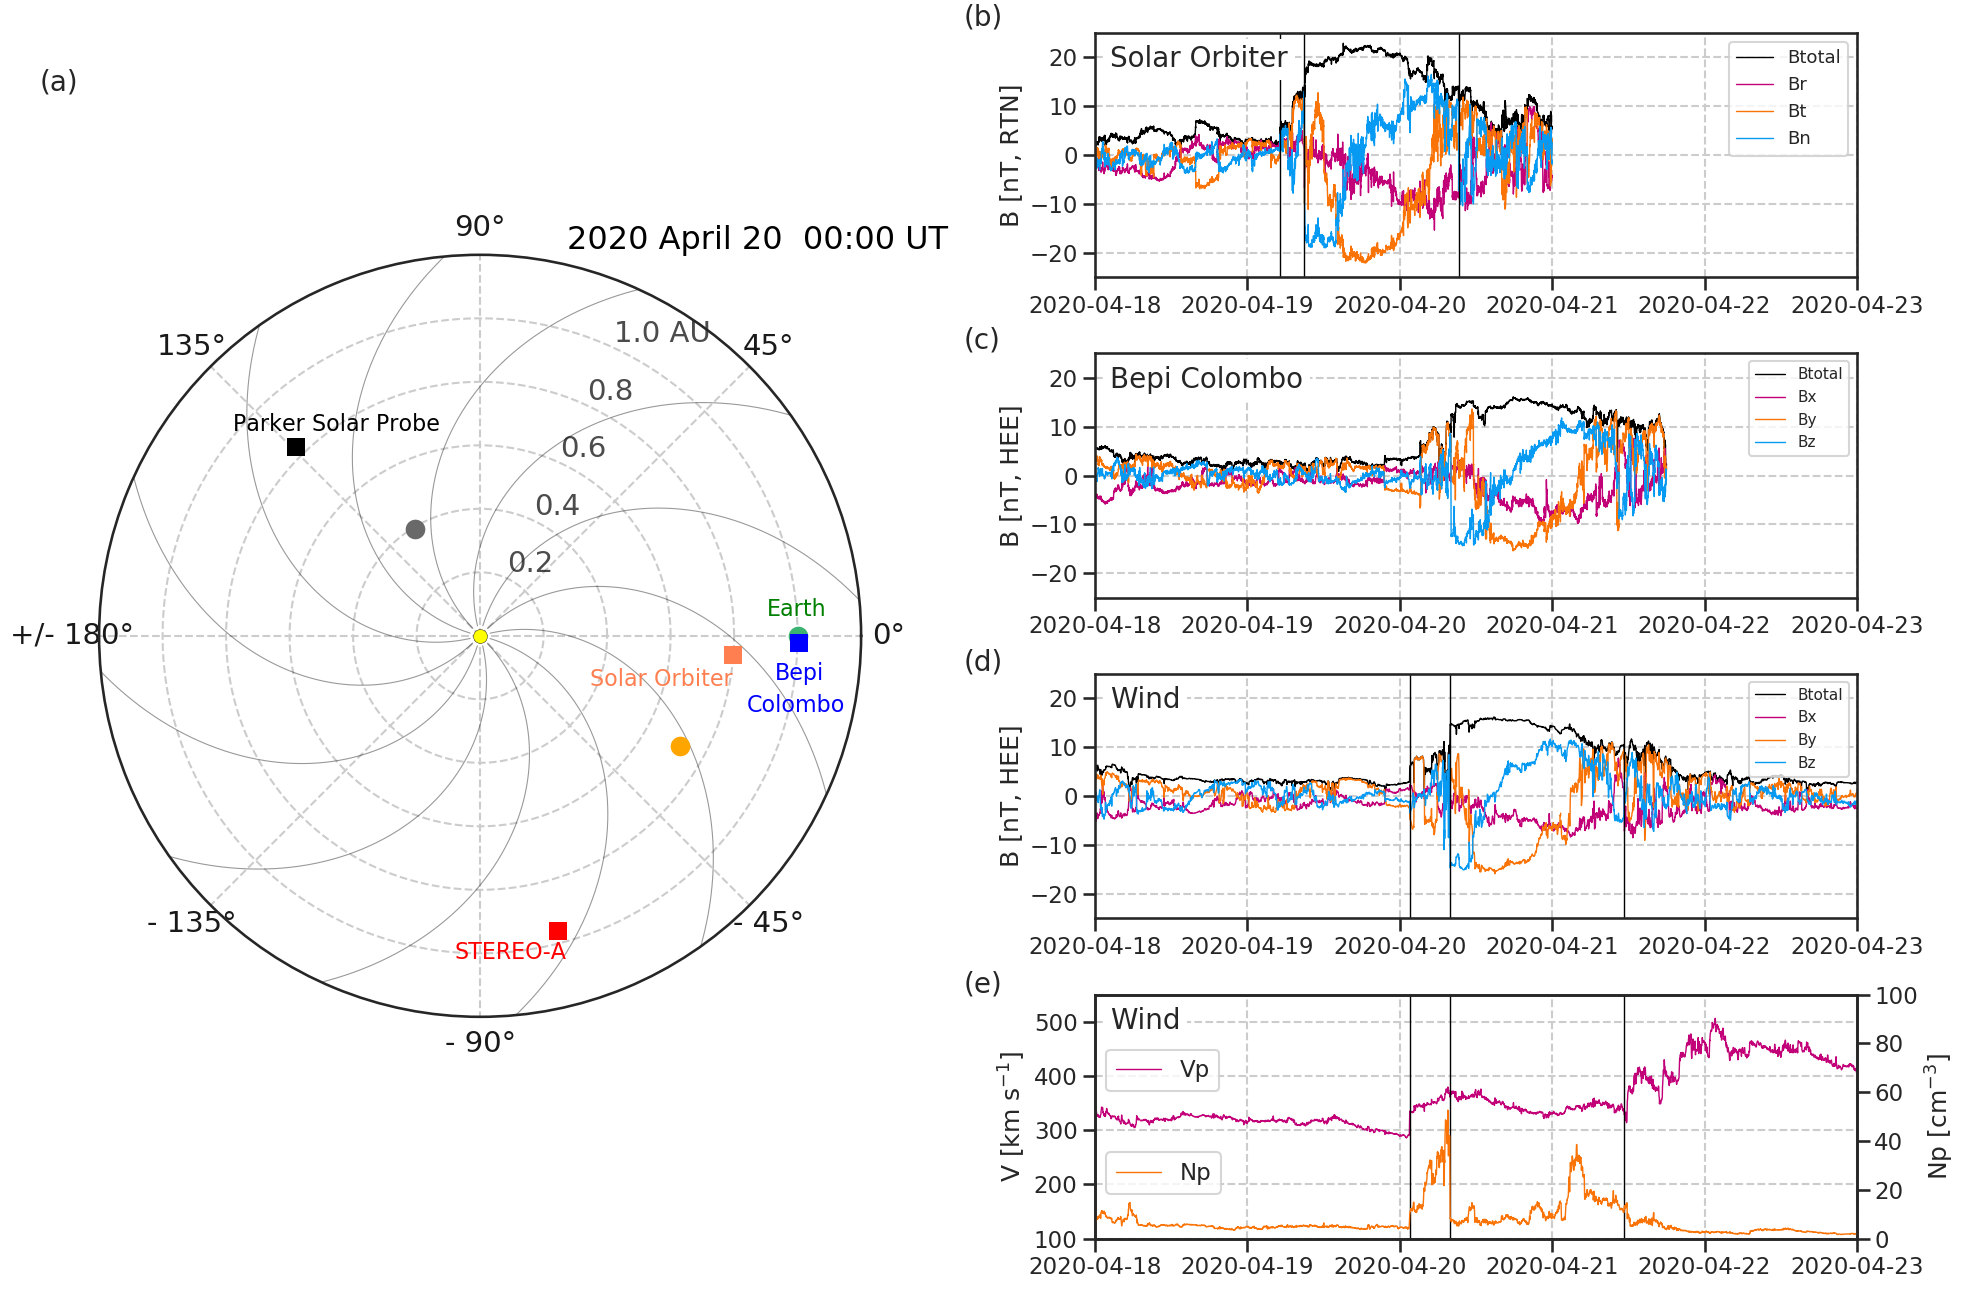

In [27]:
sns.set_context("talk")     
#sns.set_style('darkgrid')
sns.set_style('whitegrid')
sns.set_style("ticks",{'grid.linestyle': '--'})



#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-20 17:08').datetime)[0]
win.bt[windspike_ind[0:2]]=np.nan
win.bx[windspike_ind[0:2]]=np.nan
win.by[windspike_ind[0:2]]=np.nan
win.bz[windspike_ind[0:2]]=np.nan


#set wind awkward data points to nan
windspike_ind=np.where(win.time > parse_time('2020-04-21 01:20').datetime)[0]
win.bt[windspike_ind[0:1]]=np.nan
win.bx[windspike_ind[0:1]]=np.nan
win.by[windspike_ind[0:1]]=np.nan
win.bz[windspike_ind[0:1]]=np.nan


plotstart=datetime.datetime(2020, 4, 18)
plotend=datetime.datetime(2020, 4,23)
blim=25








plt.figure(1,figsize=(20, 13),dpi=100)

#define subplot grid
ax1 = plt.subplot2grid((4, 2), (0, 1))  #solo b
ax2 = plt.subplot2grid((4, 2), (1, 1))  #bepib
ax3 = plt.subplot2grid((4, 2), (2, 1))  #wind b
ax4 = plt.subplot2grid((4, 2), (3, 1))  #wind v


ax5 = plt.subplot2grid((4, 2), (0, 0), rowspan=4, projection='polar') #positions


#########################################################################
backcolor='black'
psp_color='black'
bepi_color='blue'
solo_color='coral'

symsize_planet=200
symsize_spacecraft=150
fsize=20
plot_orbit=True
fadeind=150

plot_parker=True

AUkm=149597870.7   

#for parker spiral   
theta=np.arange(0,np.deg2rad(180),0.01)

#Coordinate System
#frame='HCI'
frame='HEEQ'
print(frame)

#sidereal solar rotation rate
if frame=='HCI': sun_rot=24.47
#synodic
if frame=='HEEQ': sun_rot=26.24

frame_time_num=mdates.date2num(parse_time('2020-Apr-20').datetime)
print( 'current frame_time_num', str(mdates.num2date(frame_time_num)))

#these have their own times
dct=frame_time_num-psp.time
psp_timeind=np.argmin(abs(dct))

dct=frame_time_num-bepi.time
bepi_timeind=np.argmin(abs(dct))

dct=frame_time_num-solo.time
solo_timeind=np.argmin(abs(dct))

dct=frame_time_num-sta.time
sta_timeind=np.argmin(abs(dct))

#all same times
dct=frame_time_num-earth.time
earth_timeind=np.argmin(abs(dct))


ax5.scatter(venus.lon[earth_timeind], venus.r[earth_timeind]*np.cos(venus.lat[earth_timeind]), s=symsize_planet, c='orange', alpha=1,lw=0,zorder=3)
ax5.scatter(mercury.lon[earth_timeind], mercury.r[earth_timeind]*np.cos(mercury.lat[earth_timeind]), s=symsize_planet, c='dimgrey', alpha=1,lw=0,zorder=3)
ax5.scatter(earth.lon[earth_timeind], earth.r[earth_timeind]*np.cos(earth.lat[earth_timeind]), s=symsize_planet, c='mediumseagreen', alpha=1,lw=0,zorder=3)
ax5.scatter(sta.lon[earth_timeind], sta.r[earth_timeind]*np.cos(sta.lat[earth_timeind]), s=symsize_spacecraft, c='red', marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(mars.lon[earth_timeind], mars.r[earth_timeind]*np.cos(mars.lat[earth_timeind]), s=symsize_planet, c='orangered', alpha=1,lw=0,zorder=3)

ax5.scatter(psp.lon[psp_timeind], psp.r[psp_timeind]*np.cos(psp.lat[psp_timeind]), s=symsize_spacecraft, c=psp_color, marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(bepi.lon[bepi_timeind], bepi.r[bepi_timeind]*np.cos(bepi.lat[bepi_timeind]), s=symsize_spacecraft, c=bepi_color, marker='s', alpha=1,lw=0,zorder=3)
ax5.scatter(solo.lon[solo_timeind], solo.r[solo_timeind]*np.cos(solo.lat[solo_timeind]), s=symsize_spacecraft, c=solo_color, marker='s', alpha=1,lw=0,zorder=3)
 

#parker spiral
if plot_parker:
    for q in np.arange(0,12):
        omega=2*np.pi/(sun_rot*60*60*24) #solar rotation in seconds
        v=400/AUkm #km/s
        r0=695000/AUkm
        r=v/omega*theta+r0*7
        ax5.plot(-theta+np.deg2rad(0+(360/24.47)*1+360/12*q), r, alpha=0.4, lw=0.8,color='black',zorder=1)

#set axes and grid
ax5.set_theta_zero_location('E')
#plt.thetagrids(range(0,360,45),(u'0\u00b0 '+frame+' longitude',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='right', fmt='%d',fontsize=fsize-1,color=backcolor, alpha=0.9)
plt.thetagrids(range(0,360,45),(u'0\u00b0',u'45\u00b0',u'90\u00b0',u'135\u00b0',u'+/- 180\u00b0',u'- 135\u00b0',u'- 90\u00b0',u'- 45\u00b0'), ha='center', fmt='%d',fontsize=fsize+1,color=backcolor, alpha=0.9,zorder=4)

#plt.rgrids((0.10,0.39,0.72,1.00,1.52),('0.10','0.39','0.72','1.0','1.52 AU'),angle=125, fontsize=fsize,alpha=0.9, color=backcolor)
plt.rgrids((0.2,0.4,0.6,0.8,1.0),('0.2','0.4','0.6','0.8','1.0 AU'),angle=65, fontsize=fsize+1,alpha=0.7, color=backcolor)

#ax.set_ylim(0, 1.75) #with Mars
ax5.set_ylim(0, 1.2) 

#Sun
ax5.scatter(0,0,s=100,c='yellow',alpha=1, edgecolors='black', linewidth=0.3)



#spacecraft labels
ax5.text(psp.lon[psp_timeind]-0.2,psp.r[psp_timeind],'Parker Solar Probe', color=psp_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(solo.lon[solo_timeind]-0.05,solo.r[solo_timeind],'Solar Orbiter', color=solo_color, ha='right',fontsize=fsize-4,verticalalignment='top')
ax5.text(bepi.lon[bepi_timeind]-0.06,bepi.r[bepi_timeind],'Bepi', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(bepi.lon[bepi_timeind]-0.16,bepi.r[bepi_timeind],'Colombo', color=bepi_color, ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(sta.lon[sta_timeind]-0.16,sta.r[sta_timeind],'STEREO-A', color='red', ha='center',fontsize=fsize-4,verticalalignment='top')
ax5.text(earth.lon[earth_timeind]+0.12,earth.r[earth_timeind],'Earth', color='green', ha='center',fontsize=fsize-4,verticalalignment='top')



#time
ax5.text(1.35,1.25,mdates.num2date(frame_time_num).strftime("%Y %B %d  %H:%M")+' UT',fontsize=fsize+3, ha='left',c='black')






#################### Solo MAG

ax1.plot(sm.time, sm.bt, "k-", lw=1,label='Btotal')
ax1.plot(sm.time, sm.bx, "r-", color="xkcd:magenta", lw=1, label='Br')
ax1.plot(sm.time, sm.by, "g-", color="xkcd:orange", lw=1,label='Bt')
ax1.plot(sm.time, sm.bz, "b-", color="xkcd:azure", lw=1,label='Bn')
    
#plot vertical lines
ax1.plot_date([sicme_start_time,sicme_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_start_time,smo_start_time],[-500,500],'-k',linewidth=1)            
ax1.plot_date([smo_end_time,smo_end_time],[-500,500],'-k',linewidth=1)            

ax1.set_ylabel('B [nT, RTN]')
ax1.set_xlim(plotstart,plotend)
ax1.set_ylim(-blim,blim)
ax1.legend(loc=1,ncol=1,fontsize=13)
ax1.grid(True)


#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(sm.r[sicme_start_ind],3))+' ' +str(np.round(sm.lat[sicme_start_ind],2))+'  '+\
#         str(np.round(sm.lon[sicme_start_ind],2)),fontsize=13)



############################## Bepi MPO MAG

ax2.plot(bm.time, bm.bt, "k-", lw=1,label='Btotal')
ax2.plot(bm.time, bm.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax2.plot(bm.time, bm.by, "g-", color="xkcd:orange", lw=1,label='By')
ax2.plot(bm.time, bm.bz, "b-", color="xkcd:azure", lw=1,label='Bz')

ax2.set_ylabel('B [nT, HEE]')
ax2.set_xlim(plotstart,plotend)
ax2.set_ylim(-blim,blim)
ax2.legend(loc=1,ncol=1,fontsize=11)
ax2.grid(True)



############################## Wind MFI
    
#plt.title('Wind MFI')

ax3.plot(win.time, win.bt, "k-", lw=1,label='Btotal')
ax3.plot(win.time, -win.bx,'-r', color="xkcd:magenta",linewidth=1,label='Bx')
ax3.plot(win.time, -win.by, "g-", color="xkcd:orange", lw=1,label='By')
ax3.plot(win.time, win.bz, "b-", color="xkcd:azure", lw=1,label='Bz')


#plot vertical lines
ax3.plot_date([wicme_start_time,wicme_start_time],[-500,500],'-k',linewidth=1)            
ax3.plot_date([wmo_start_time,wmo_start_time],[-500,500],'-k',linewidth=1)            
ax3.plot_date([wmo_end_time,wmo_end_time],[-500,500],'-k',linewidth=1)            

ax3.set_ylabel('B [nT, HEE]')
ax3.set_xlim(plotstart,plotend)
ax3.set_ylim(-blim,blim)
ax3.legend(loc=1,ncol=1,fontsize=11)
ax3.grid(True)

#position on figure
#textstart=plotstart+datetime.timedelta(hours=2)
#plt.text(textstart,25,'HEEQ R/lat/lon: '+str(np.round(win.r[wicme_start_ind],3))+' ' +str(np.round(win.lat[wicme_start_ind],2))+'  '+\
#         str(np.round(win.lon[wicme_start_ind],2)),fontsize=13)


#plt.tight_layout()



############################## Wind SWE


#speed
ax4.plot(win.time, win.vt, color="xkcd:magenta",linewidth=1,label='Vp')

ax4.plot_date([wicme_start_time,wicme_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_start_time,wmo_start_time],[-500,1000],'-k',linewidth=1)            
ax4.plot_date([wmo_end_time,wmo_end_time],[-500,1000],'-k',linewidth=1)            

ax4.set_ylabel('V [km $\mathrm{s^{-1}}$]')
ax4.set_xlim(plotstart,plotend)
ax4.set_ylim(100,550)
ax4.grid(True)



#density
ax5=ax4.twinx()
ax5.plot(win.time, win.np, color="xkcd:orange", lw=1,label='Np')
ax5.set_ylim(0,100)
ax5.set_ylabel('Np $[\mathrm{cm^{-3}}]$')

ax4.legend(loc=2,bbox_to_anchor=(0.0,0.82))
ax5.legend(loc=2,bbox_to_anchor=(0.0,0.4))



plt.tight_layout()

#annotations

vshift=0.25
plt.annotate('(a)',[0.02,0.93],xycoords='figure fraction',fontsize=20)
plt.annotate('(b)',[0.49,0.98],xycoords='figure fraction',fontsize=20)
plt.annotate('(c)',[0.49,0.98-vshift*1],xycoords='figure fraction',fontsize=20)
plt.annotate('(d)',[0.49,0.98-vshift*2],xycoords='figure fraction',fontsize=20)
plt.annotate('(e)',[0.49,0.98-vshift*3],xycoords='figure fraction',fontsize=20)



ax1.text(0.02,0.86,'Solar Orbiter',transform=ax1.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))
ax2.text(0.02,0.86,'Bepi Colombo',transform=ax2.transAxes,fontsize=20, bbox=dict(facecolor='white', alpha=1))
ax3.text(0.02,0.86,'Wind',transform=ax3.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))
ax4.text(0.02,0.86,'Wind',transform=ax4.transAxes,fontsize=20,bbox=dict(facecolor='white', alpha=1))




plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview2.png')
plt.savefig('/home/cmoestl/pycode/heliocats/results/davies_2020/figure1_overview2.pdf')